# Dallas Shoting Twitter Analysis

In [64]:
from __future__ import division
import json
import codecs
import unidecode
import string
import vincent
import pandas
import pytz
import operator
import numpy as np
from datetime import datetime as dt
from vincent import AxisProperties, PropertySet, ValueRef
from tweetokenize import Tokenizer
from collections import Counter
from nltk.corpus import stopwords
from nltk import bigrams, trigrams
from collections import defaultdict
import matplotlib.pyplot as plt

data_path = '../data/all_data.dat'

In [2]:
all_raw_text = []
all_tweet_json = []
with open(data_path) as data_file:
    for line in data_file.readlines():
        line = line.strip()
        if len(line) > 0 :
            tweet = json.loads(line)
            #Otherwise it is a timestamp (i.e. {u'limit': {u'track': 2, u'timestamp_ms': u'1468524474061'}})
            if 'text' in tweet: 
                all_tweet_json.append(tweet)
                all_raw_text.append(tweet['text'])

## Sanity check
To make a sanity check first we analyzed the length of all the captured tweets, while calculating its mean and variance. In the results below we can see that most of the tweets have a length of the maximum permitted: 140 characters but due to the long tail we have a $\mu=117.98$ and $\sigma=29.47$.
However, if 140 characters is the maximum permitted, why do we find tweets that have a length greaterthan 140?

In [22]:
all_dates = []
for tweet in all_tweet_json:
    all_dates.append(dt.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC))

start_date =  min(all_dates)
end_date =  max(all_dates)

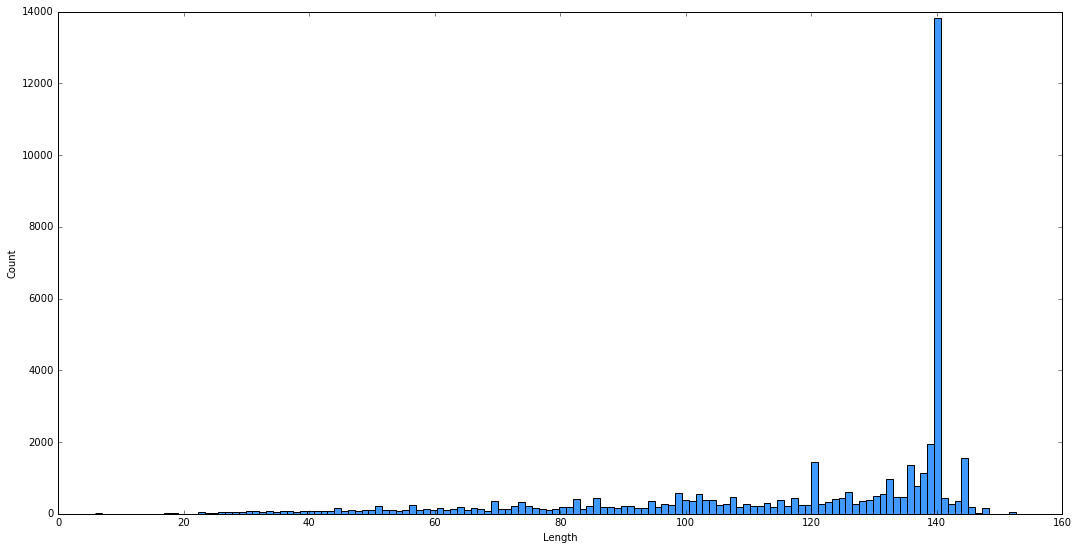

Total Tweets:  46257
Length:        mean: 117.978705926    std:29.4734919723
Start Date:    2016-07-14 04:25:12
End Date:      2016-07-14 21:38:08


In [165]:
tweet_len = [len(text) for text in all_raw_text]

plt.hist(tweet_len, bins=140, color='#4099FF')
fig_size = [18,9]
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

print 'Total Tweets: ', len(all_raw_text)
print 'Length:        mean: {}    std:{}'.format(np.mean(tweet_len), np.std(tweet_len))
print 'Start Date:   ', start_date.strftime('%Y-%m-%d %H:%M:%S')
print 'End Date:     ', end_date.strftime('%Y-%m-%d %H:%M:%S')

To understand what is going on with the large tweets we selected the first tweet that has a length above 145. The selected tweet has length of 153. It was interesting to see that the tweet had emojis (graphical emoticons) embedded and to be displayed in this Jupyter Notebook.

After looking on how emojis are encoded I found that those are officially suported by the Unicode organization and the list of officialy supported emojis are located in this [link](http://unicode.org/emoji/charts/full-emoji-list.html).
All the emojis in the selected tweet are formed by at least one long unicode character, while the US flag is formed by two which was a length of four ASCII characters. This can be seen in the list of characters from the tweet that are separated by a space. Therefore, Twitter seems to be considering the emojis as only one character while in the Unicode space it has more characters.

In [27]:
long_tweet = None
for tweet in all_tweet_json:
    if len(tweet['text']) > 145:
        long_tweet = tweet
        break

print 'Tweet length:'
print len(long_tweet)
print '\nTweet:'
print long_tweet['text']
print '\nTweet chars:'
tweet_chars = [c for c in long_tweet['text']]
print ' '.join(tweet_chars)
print '\nACII unicode escape:'
print long_tweet['text'].encode('unicode-escape')

Tweet length:
30

Tweet:
RT @O_IrishT: 🍀🇺🇸A trueAmerican🇺🇸 w/Fire in the Belly! I trust him💯%👍! Strong&amp;Steady! #TrumpTrain 🚂💨 .@Mferris67 #AmericaFirst https://t.co…

Tweet chars:
R T   @ O _ I r i s h T :   � � � � � � A   t r u e A m e r i c a n � � � �   w / F i r e   i n   t h e   B e l l y !   I   t r u s t   h i m � � % � � !   S t r o n g & a m p ; S t e a d y !   # T r u m p T r a i n   � � � �   . @ M f e r r i s 6 7   # A m e r i c a F i r s t   h t t p s : / / t . c o …

ACII unicode escape:
RT @O_IrishT: \U0001f340\U0001f1fa\U0001f1f8A trueAmerican\U0001f1fa\U0001f1f8 w/Fire in the Belly! I trust him\U0001f4af%\U0001f44d! Strong&amp;Steady! #TrumpTrain \U0001f682\U0001f4a8 .@Mferris67 #AmericaFirst https://t.co\u2026


## Frequency Analysis

In a first approach to check what the tweets are trying to say, we did a frequency analysis of words (unigrams), bigrams, hashtags and mentioned users in the tweets. For this analysis, the tweets were tokenized using a readily available [tokenizer](), which replaces the url's with a **URL** token, and numbers with the **NUMBER** token. The stopwords from the English dictionary were removed.

In [38]:
all_tokens = []
tweet_tkzr = Tokenizer(usernames=False)
stopwords_set = stopwords.words('english') + list(string.punctuation)
for tweet in all_tweet_json:
    all_tokens.append([token for token in tweet_tkzr.tokenize(tweet['text']) \
                              if token not in stopwords_set])

In [39]:
tweet_count = Counter()
hashtag_count = Counter()
bigram_count = Counter()
trigram_count = Counter()
username_count = Counter()
for tokens in all_tokens:
    tweet_count.update(tokens)
    bigram_count.update(bigrams(tokens))
    trigram_count.update(trigrams(tokens))
    hashtag_tokens = [token.upper() for token in tokens if token.startswith(('#'))]
    hashtag_count.update(hashtag_tokens)
    username_tokens = [token.lower() for token in tokens if token.startswith(('@'))]
    username_count.update(username_tokens)

### Unigrams
The list shown below is the list of the top 25 most frequent terms/words/unigrams found in the corpus.

At a word level we can see that the most common terms are **URL** and **RT**. **RT** is the term used to describe a retweet within Twitter. This indicates that it of the tweets captured in this corpus are either a retweet and contain a link to an external source.

The third most frequent word **arrest** is interesting, as most people must be talking about an arrest during the shooting.
Then we can see that **...** is quite frequent as it appears within the list in the form of three consecutive dots and the unicode char which compactly displays suspension points. This must be an indicative that most of the tweet messages could not be contained within one tweet and must have been truncated.

In this analysis we can see that the tokenizer is not as good as expected as the term **https** and **:/** appear as tokens. This requires a further analysis on how the tokenizer works and might need to improve it.

It was interesting to see names of people in this top list such as: deray, obama, mckesson and soros. Deray McKesson is one of the activists of the Black Lives Matter movement and is well known in social media as that is his weapon of choice for his social activism. Obama must refer to the President of the United Stated (POTUS) and Soros must refer to George who is according to Wikipedia:
```
George Soros is a Hungarian-American business magnate, investor, philanthropist, political activist, and author who is of Hungarian-Jewish ancestry and holds dual citizenship. He is chairman of Soros Fund Management.
```
And he has been related to the shootings of black people in the present year.

However, there are some other terms which do not bring too much meaning by themselves such as house, black, man, lives, white, like. Even if we as humans can infer that it must refer to terms such as *White House*, *Black lives matter*. We'll do an analysis based on bigrams and see if we can find those to be as frequent as the words itself.

In [40]:
row_format = u"{:>20}{:>12}{:18.4f}"
print u"{:>20}{:>12}{:>18}".format('WORD', 'FREQUENCY', 'Presence Ratio')
print u"{:>20}{:>12}{:>18}".format('----', '---------', '--------------')
for term, freq in tweet_count.most_common(25):
    print row_format.format(term, freq, freq/len(all_tweet_json))

                WORD   FREQUENCY    Presence Ratio
                ----   ---------    --------------
                 URL       30891            0.6678
                  RT       28349            0.6129
              arrest       23482            0.5076
                   …       10548            0.2280
              @deray        8486            0.1835
              NUMBER        7973            0.1724
              police        7152            0.1546
               https        6523            0.1410
                 ...        6237            0.1348
               deray        5391            0.1165
                  :/        4970            0.1074
                   I        3873            0.0837
   #BlackLivesMatter        3385            0.0732
                 BLM        3166            0.0684
               obama        2947            0.0637
               house        2396            0.0518
              people        2203            0.0476
               black        214

### Bigrams

After extracting the bigrams we did a similar experiment to the previous one and analyze the most frequent ones.

As we can see the most frequent bigram confirms that the tokenizer is not working as expected as we can see that **https** goes alongside a **column** which are terms included in URLs. If we assume that the suspension points refer to truncated tweets, then we could assume that most of the tweets that were truncated include an external link.

Then we can find more interesting concepts such as *police arrest*, *deray mckesson*, *resisting arrest*, *house arrest*, *white house*, and *martial law*. All of these terms could be considered as a search expansion term in order to obtain more information about relevant events or entities found within the corpus.

In [41]:
row_format = u"{:>20}{:>12}{:18.4f}"
print u"{:>20}{:>12}{:>18}".format('BIGRAM', 'FREQUENCY', 'Presence Ratio')
print u"{:>20}{:>12}{:>18}".format('------', '---------', '--------------')
for term, freq in bigram_count.most_common(25):
    print row_format.format(' '.join(term), freq, freq/len(all_tweet_json))

              BIGRAM   FREQUENCY    Presence Ratio
              ------   ---------    --------------
            https :/        4787            0.1035
             URL URL        2587            0.0559
                :/ …        2322            0.0502
       police arrest        2164            0.0468
             ... URL        2025            0.0438
          arrest URL        1766            0.0382
             https …        1736            0.0375
      deray mckesson        1717            0.0371
    resisting arrest        1647            0.0356
           RT @deray        1372            0.0297
        house arrest        1344            0.0291
       arrest NUMBER        1243            0.0269
         white house        1067            0.0231
           URL https        1049            0.0227
          lives home        1023            0.0221
               :/ t…        1012            0.0219
          home owned         991            0.0214
             URL via         98

### Hastags

Hashtags are important within Twitter and those can be seen as user topic labelling of the content they provide.

In the following frequent analysis we see that they most frequent ones were **#BLACKLIVESMATTER** and **#BLM** which is an acronym of the first one. This is no surprise as this was the term used while searching for tweets related to the Dallas shooting event. 

In [43]:
print u"{:>20}{:>12}{:>18}".format('HASHTAG', 'FREQUENCY', 'Presence Ratio')
print u"{:>20}{:>12}{:>18}".format('-------', '---------', '--------------')
for term, freq in hashtag_count.most_common(25):
    print row_format.format(term, freq, freq/len(all_tweet_json))

             HASHTAG   FREQUENCY    Presence Ratio
             -------   ---------    --------------
   #BLACKLIVESMATTER        3698            0.0799
                #BLM        1016            0.0220
         #BATONROUGE         726            0.0157
        #CNNTOWNHALL         399            0.0086
        #ARRESTARNAB         307            0.0066
              #DERAY         241            0.0052
         #PCGONEWILD         228            0.0049
      #ALTONSTERLING         213            0.0046
         #AMBERALERT         178            0.0038
               #TCOT         168            0.0036
      #STOPZAKIRNAIK         151            0.0033
              #SOROS         143            0.0031
           #THISFLAG         142            0.0031
               #NEWS         138            0.0030
       #PRESSTITUTES         138            0.0030
             #ARREST         134            0.0029
           #CNNTOWNH         114            0.0025
           #BRUSSELS         10

As we can see must of the hashtags are related to the topic describing similar previous events such as *Baton Rouge* in Louisiana. Press events related to politics such as **#CNNTOWNHALL**, **#CNNTOWNH** which refer to the *CNN Town Hall* discussion which took place on the same day. Follwing that **#NEWS** and **#PRESSTITUTES** show that people were mentioning events on the News and their discontent about the event taking place on National TV through he news. 

The hashtag **#ARRESTARNAB** might give us a better idea of to who did the *arrest* term that appeared in the previous analysis may refer to.

The hashtag **#TCOT** refers to *Top Conservatives on Twitter* claiming that the social media was being manipulated by the conservative parties within the US.

But then we found some unrelated hashtags referring to other topics and locations such as: **#PCGONEWILD**, **#BRUSSELS**, **#BELGIUM**, **#BRUSSELSAIRPORT** and **#IRAN**. For this reason it was convenient to check the tweets that contained these hashtags and get a better idea of what is going on.

**Unrelated tweets**

In [53]:
wtf_terms = ['#PCGONEWILD', '#BRUSSELS', '#BELGIUM', '#BRUSSELSAIRPORT', '#IRAN']
unknown_tweet_set = set()
for tweet in all_tweet_json:
    if any(term in tweet['text'].upper() for term in wtf_terms):
        unknown_tweet_set.add(tweet['text'])
        
for idx, unk in zip(range(1,len(unknown_tweet_set)+1), unknown_tweet_set):
    print '(%d) %s\n'%(idx,unk)

(1) Belgian police make arrest after #Brussels bombings as friends... https://t.co/UiTftjPy2o

(2) RT @daniyal_kalhor: @free_taheri @EPPGroup Today's arrest of #MATaheri 's students in #Iran during protest
#freetaheri
#prisoner_of_conscie…

(3) Arrest made in attack on #Belgium; Ex-Marist basketball player... https://t.co/0U3wYrcM6Y #brusselsairport #brussels

(4) Belgian police make arrest after #Brussels bombings as friends... https://t.co/pJwcQJ5svY

(5) RT @steph93065: German police raid 60 citizens homes for the crime of "Xenophobia" because of their Facebook posts; arrest 40.
#PCgoneWild

(6) Armed police arrest two men in hunt for #Brussels terrorists... https://t.co/UfwbUObKkm

(7) Armed police arrest two men in hunt for Brussels terrorists... https://t.co/d8Z1oXrp8t #Brussels

(8) German police raid 60 citizens homes for the crime of "Xenophobia" because of their Facebook posts; arrest 40.
#PCgoneWild

(9) RT @daniyal_kalhor: Stop the illegal arrest of #Mohammad_Ali_Taheri , t

***
Wow! As we can see these terms belong to another event which took place on the same day. This is a great discovery that must be taken in consideration while dealing with Twitter data, as both events seem to have in common the term **arrest**, therefore both events were captured while collecting the data. This should be considered as noise while trying to extract the events that happened during the Dallas shooting.

### Mentioned usernames

The overwhelming top mentioned username **@deray** belongs to the account of Deray McKesson, the activist we mentioned before, while the second one **@potus** refers to the official account of the President of the United States. 

The third most mentioned username **@handymayhem** belongs to an activist of the *Black Lives Matter* movement, who names himself **Uncle Hotep** and has a popular podcast that can be listened to in [Sound Cloud](https://soundcloud.com/handymayhem). We can find that other mentioned usernames actually belong to the press or have means of divulging information through the internet via podcast, weblogs or online press, the usernames that belong to this list are:

1. **@reignofapril**  (April) Managing editor
2. **@wesleylowery**  (Wesley Lowery) The Washington Post reporter Reporter
3. **@prisonplanet**  (Paul Joseph Watson) - self-claimed contrarian polemicist from London
4. **@actualidadrt**  (RT in Spanish) - Online press
5. **@usds**          (US Digital Services) - online department from the White House
6. **@theintercept**  (The Intercept) - Online press
7. **@robertmackey**  (Robert Mackey) - Senior writer and reporter for The Lede
8. **@scrowder**      (Steven Crowder) Podcaster and videoblogger
9. **@ap**           (American Press) - Online press

All the other usernames seem to be either and activist or political figure or critic.

It would be important to be able to automatically determine which accounts belong to the press as this might be a good source of information to extract the events that happened during an incident.

In [61]:
print u"{:>20}{:>12}{:>18}".format('USERNAME', 'FREQUENCY', 'Presence Ratio')
print u"{:>20}{:>12}{:>18}".format('--------', '---------', '--------------')
for term, freq in username_count.most_common(25):
    print row_format.format(term, freq, freq/len(all_tweet_json))

            USERNAME   FREQUENCY    Presence Ratio
            --------   ---------    --------------
              @deray        8964            0.1938
              @potus        1092            0.0236
        @handymayhem         803            0.0174
          @xpayneart         622            0.0134
            @ten_gop         528            0.0114
         @jaredwyand         514            0.0111
               @nero         493            0.0107
       @wesleylowery         406            0.0088
       @prisonplanet         393            0.0085
          @bdell1014         376            0.0081
       @actualidadrt         360            0.0078
         @benshapiro         349            0.0075
               @usds         339            0.0073
     @politicalshort         323            0.0070
       @iowahawkblog         314            0.0068
           @wdfx2eu2         306            0.0066
       @theintercept         277            0.0060
        @_tiffany_co         27

## Removing the Redundancy

Through the unigram and bigram analysis we could see that the most common terms were the term RT (re-tweet), terms related to URLs. In an attempt to remove the redundancy of information that the possible retweets might be generating, it seems natural to make a retweet analysis and remove the retweets from our original corpus while excavating more relevant information.

After counting the repeated tweets we found that from the 46,257 tweets found in the corpus only **23,215** unique tweets, from which 2,472 were repeated and 2,310 were tagged with an **RT**. This means that we found a total of 20,743 tweets that appeared only once through the whole corpus and a total of **16,089** URLs were found.

In [86]:
tweet_text_counter = {}
for tweet in all_tweet_json:
    tweet_text = tweet['text']
    if tweet_text in tweet_text_counter:
        tweet_text_counter[tweet_text] += 1
    else:
        tweet_text_counter[tweet_text] = 1

tweet_text_counter = sorted(tweet_text_counter.items(), key=lambda x:x[1], reverse=True)

unique_tweets = [text for text, count in tweet_text_counter]

print 'Total tweets:           ', sum([count for text, count in tweet_text_counter])
print 'Number unique tweets:   ', len(tweet_text_counter)
print 'Repeated tweet:         ', sum([1 for text, count in tweet_text_counter if count > 1])
print 'Repeated with RT:       ', sum([1 for text, count in tweet_text_counter if u'RT' in text and count > 1])
print 'Repeated without RT:    ', sum([1 for text, count in tweet_text_counter if u'RT' not in text and count > 1])
print 'Non-repeated tweets:    ', sum([1 if count==1 else 0 for text, count in tweet_text_counter])
print 'Tweets with URLs:       ', sum([1 for text, count in tweet_text_counter if u'http' in text])

Total tweets:            46257
Number unique tweets:    23215
Repeated tweet:          2472
Repeated with RT:        2310
Repeated without RT:     162
Non-repeated tweets:     20743
Tweets with URLs:        16089


If we make a bigram analysis over our corpus after removing all the repeated tweets, we can see that we might get more information from these phrases. 
For instance, we can observe in the top 25 bigrams new phrases as *resisting arrest*, *plan america*, *cardiac arrest* and a couple of emojis together of people laughing.

In [96]:
unique_bigram_count = Counter()
for text in unique_tweets:
    tokens = [token for token in tweet_tkzr.tokenize(text) if token not in stopwords_set]
    unique_bigram_count.update(bigrams(tokens))

print u"{:>20}{:>12}{:>18}".format('BIGRAM', 'FREQUENCY', 'Presence Ratio')
print u"{:>20}{:>12}{:>18}".format('------', '---------', '--------------')
for term, freq in unique_bigram_count.most_common(25):
    print row_format.format(' '.join(term), freq, freq/len(all_tweet_json))

              BIGRAM   FREQUENCY    Presence Ratio
              ------   ---------    --------------
             URL URL        1459            0.0315
       police arrest        1458            0.0315
             ... URL        1427            0.0308
      deray mckesson        1135            0.0245
    resisting arrest         922            0.0199
         martial law         884            0.0191
           BLM deray         852            0.0184
         america URL         842            0.0182
       loretta lynch         838            0.0181
            law plan         837            0.0181
        plan america         835            0.0181
       lynch martial         833            0.0180
    mckesson loretta         833            0.0180
          arrest URL         780            0.0169
             URL via         737            0.0159
                 … …         690            0.0149
            https :/         622            0.0134
        house arrest         61

At this point we know that several tweets are formed by RT that contain hyperlinks. Now let us see what happens if we remove the URL and RT related tokens. In the table below we can see that even more information appears, although that information belongs to another event as it refers to people from the Middle East and some bigrams are in Hindi (अन्याय बंद = Stop Injustice and बंद हो = Closed) referring to another event related to [Asaram Bapuji](https://en.wikipedia.org/wiki/Asaram) who is a religious leader.

In [98]:
unique_bigram_count = Counter()
url_token_set = ['http','https', ':/', 'URL', '...']
for text in unique_tweets:
    tokens = [token for token in tweet_tkzr.tokenize(text) if token not in stopwords_set and token not in url_token_set]
    unique_bigram_count.update(bigrams(tokens))

print u"{:>20}{:>12}{:>18}".format('BIGRAM', 'FREQUENCY', 'Presence Ratio')
print u"{:>20}{:>12}{:>18}".format('------', '---------', '--------------')
for term, freq in unique_bigram_count.most_common(25):
    print row_format.format(' '.join(term), freq, freq/len(all_tweet_json))

              BIGRAM   FREQUENCY    Presence Ratio
              ------   ---------    --------------
       police arrest        1458            0.0315
      deray mckesson        1135            0.0245
    resisting arrest         922            0.0199
         martial law         884            0.0191
           BLM deray         853            0.0184
       loretta lynch         838            0.0181
            law plan         837            0.0181
        plan america         835            0.0181
    mckesson loretta         833            0.0180
       lynch martial         833            0.0180
                 … …         710            0.0153
        house arrest         617            0.0133
       arrest NUMBER         605            0.0131
      cardiac arrest         526            0.0114
        lives matter         365            0.0079
         black lives         364            0.0079
         baton rouge         351            0.0076
               😂 😂         348 

### URLs analysis
The top 10 most repeated tweets list show that the most repeated tweet was appeared 660 times, and most of the repeated tweets have a URL. This was an invitation to make a URL analysis.

#### Top 10 most repeated tweets

In [82]:
display_num = 10
for idx, tweet_text in zip(range(1,display_num+1),tweet_text_counter[:display_num]):
    print '(%d) [%d] %s'%(idx, tweet_text[1], tweet_text[0])

(1) [660] RT @handymayhem: Deray crib in Baltimore....you sleep comfy being an activist

#BlackLivesMatter https://t.co/IKvo018rWj
(2) [481] RT @deray: He was in jail with us, the police need to be held accountable for assaulting him like this. #BatonRouge https://t.co/PMDrDzZq2i
(3) [377] RT @Nero: Didn't know @deray lived in such luxury. Not exactly the 'hood... https://t.co/Nm5QhGpopv
(4) [348] RT @ActualidadRT: ÚLTIMA HORA: Muere asesinado el policía federal que arrestó a 'El Chapo' Guzmán https://t.co/hOC0lMbcqV https://t.co/5WY7…
(5) [313] RT @iowahawkblog: The people who howl about keeping govt out of your bedroom are the first ones who will arrest you for renting it out
http…
(6) [279] RT @TEN_GOP: Just a reminder: #BLM leader @deray lives in home owned by Soros! https://t.co/vtG4EdS0au
(7) [277] RT @JaredWyand: AGAIN: NYTimes - Blacks are 20% less likely to be shot during an arrest than Whites!

BLM is a fraud!

#CNNTownHall https:/…
(8) [265] RT @benshapiro: Racial healer Oba

***
After searching for the unique URLs found within the corpus, we obtained a total of 7,597 unique URLs from which 2,278 were repeated at least once. The most repeated URLs redirect to other sources such as news websites or blogs that write about the comfortable life that Deray McKeeson has, he is one of the most important persons in the Black Lives Matter movement.

However, if we give a closer look to the following tweets, some of them give relevant information in regard to the event as these links [1](http://www.cjr.org/q_and_a/ryan_kailath.php) and [2](https://theintercept.com/2016/07/14/baton-rouge-police-sued-arrest-peaceful-protesters/).

It was funny to find out that some URLs implicitly are a retweet as they refer to a specific tweet, which Twitter knows how to handle a special display.

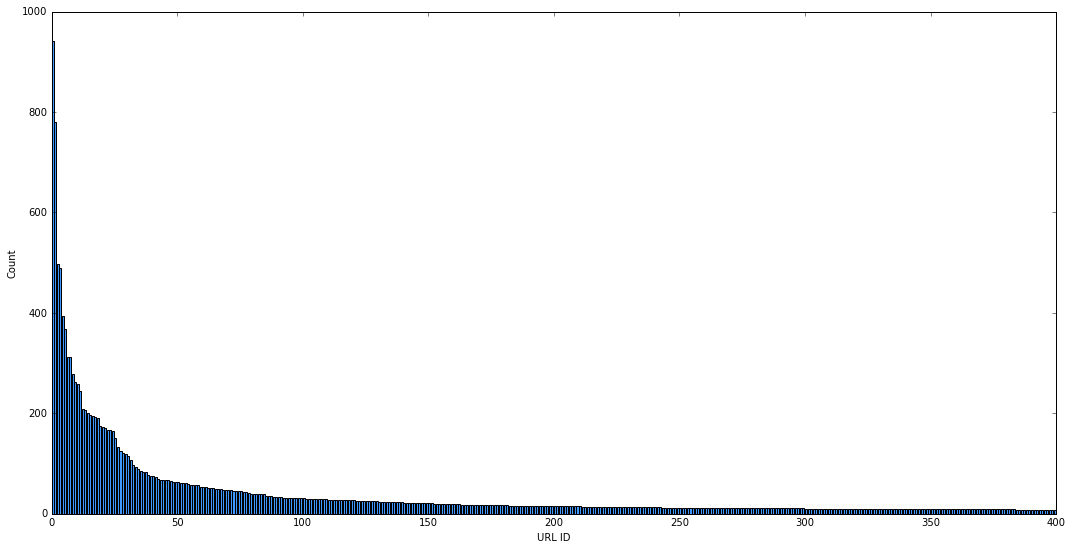

Number unique urls:    7597
Repeated urls:         2278
Non-repeated urls:     5319
[942] - http://www.theamericanmirror.com/blacklivesmatter-leader-deray-lives-home-owned-by-soros-connected/
[781] - https://wp.me/p6uZrJ-76q/
[497] - https://twitter.com/handymayhem/status/753591942349455361
[489] - https://twitter.com/thelifeofdparty/status/753278578184171520
[393] - http://www.breitbart.com/big-government/2016/07/13/police-arrest-41-black-lives-matter-protest-calling-abolition-policing/
[367] - http://es.rt.com/4key
[313] - https://twitter.com/latimes/status/753372203668934656
[312] - https://twitter.com/antoniosabatojr/status/743472937768869888
[278] - https://amp.twimg.com/v/52a257a9-a270-46f4-a859-85fb300b4265
[263] - https://twitter.com/natishafooksw2b/status/753451485904539648
[258] - https://www.washingtonpost.com/news/post-politics/wp/2016/07/14/inside-obamas-radical-experiment-in-national-reconciliation/
[244] - https://twitter.com/JhaSanjay/status/753480114898341888
[209] - h

In [170]:
tweet_url_counter = {}
for tweet in all_tweet_json:
    if u'entities' not in tweet:
        continue
    if u'urls' not in tweet[u'entities']:
        continue
    for urls in tweet[u'entities']['urls']:
        if urls[u'expanded_url'] in tweet_url_counter:
            tweet_url_counter[urls[u'expanded_url']] += 1
        else:
            tweet_url_counter[urls[u'expanded_url']] = 1

tweet_url_counter = sorted(tweet_url_counter.items(), key=lambda x:x[1], reverse=True)

url_bar_count = [count for text, count in tweet_url_counter]
plt.bar(np.arange(400), url_bar_count[:400], color='#4099FF')
plt.xlabel('URL ID')
plt.ylabel('Count')
plt.show()

print 'Number unique urls:   ', len(tweet_url_counter)
print 'Repeated urls:        ', sum([1 if count>1 else 0 for text, count in tweet_url_counter])
print 'Non-repeated urls:    ', sum([1 if count==1 else 0 for text, count in tweet_url_counter])

for text, count in tweet_url_counter[:25]:
    print u"[{}] - {}".format(count, text)

## Word correlation

Even if bigrams can tell us a lot of information by expanding the window search from 1 word to 2 words, it does not capture long term dependencies. For that reason, another experiment to do at word level is check the most common term correlations.

In [102]:
com = defaultdict(lambda : defaultdict(int))
 
for text in unique_tweets:
    # Build co-occurrence matrix
    tokens = [token for token in tweet_tkzr.tokenize(text) \
              if token not in stopwords_set \
              and token not in url_token_set \
              and token not in ['RT', '...']]
    for i in range(len(tokens)-1):            
        for j in range(i+1, len(tokens)):
            w1, w2 = sorted([tokens[i], tokens[j]])                
            if w1 != w2:
                com[w1][w2] += 1

In [242]:
com_max = []
# For each term, look for the most common co-occurrent terms
for t1 in com:
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
# Get the most frequent co-occurrences
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)

for terms, count in terms_max[:15]:
    print row_format.format(' '.join(terms), count, count/len(all_tweet_json))

       arrest police        2951            0.0638
       NUMBER arrest        2425            0.0524
            arrest …        1150            0.0249
      deray mckesson        1138            0.0246
    arrest resisting        1106            0.0239
           BLM deray        1003            0.0217
            I arrest         958            0.0207
        BLM mckesson         913            0.0197
         law martial         885            0.0191
         BLM martial         881            0.0190
       america deray         878            0.0190
       NUMBER police         873            0.0189
             BLM law         859            0.0186
           deray law         856            0.0185
               BLM …         845            0.0183


***
If we look at the most frequently correlated terms we have pretty much the results that we obtained before. 
For this reason we digged a little bit deeper into the tail of the frequency, we could findi more relevant correlated terms such as *sheriff and willis*, *alan* and many other terms and *hunt* alongside other words. 

In [243]:
for terms, count in terms_max[2010:2025]:
    print row_format.format(' '.join(terms), count, count/len(all_tweet_json))

          hunt leads          20            0.0004
         hunt return          20            0.0004
          hunt witch          20            0.0004
        leads return          20            0.0004
         leads witch          20            0.0004
         alan office          20            0.0004
         alan willis          20            0.0004
         alan county          20            0.0004
      alan sheriff's          20            0.0004
         alan dekalb          20            0.0004
           ali leads          20            0.0004
      ali electronic          20            0.0004
          ali return          20            0.0004
         ali shaukat          20            0.0004
           nothing …          20            0.0004


## LDA Topic Modelling

In an attempt to make a smarter search within the data, we made an LDA topic modelling based on the unique tweets, we looked for 10 topics described with 5 words. The results were the following:

In [118]:
import gensim
from gensim import corpora, models

unique_tokens = []
for text in unique_tweets:
    tokens = [token for token in tweet_tkzr.tokenize(text) \
              if token not in stopwords_set \
              and token not in url_token_set \
              and token not in ['RT', '...']]
    unique_tokens.append(tokens)

dictionary = corpora.Dictionary(unique_tokens)
corpus = [dictionary.doc2bow(tokens) for tokens in unique_tokens]
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)

for elem in ldamodel.print_topics(num_topics=10, num_words=5):
    print elem

(0, u'0.071*arrest + 0.011*nothing + 0.010*NUMBER + 0.009*police + 0.007*\u2019')
(1, u'0.043*arrest + 0.012*pokemon + 0.011*co + 0.011*players + 0.010*el')
(2, u'0.054*@deray + 0.037*\u2026 + 0.033*I + 0.020*deray + 0.014*like')
(3, u'0.042*arrest + 0.010*@deray + 0.007*women + 0.007*good + 0.007*warrant')
(4, u'0.032*@deray + 0.031*\U0001f602 + 0.025*arrest + 0.022*NUMBER + 0.011*\u2019')
(5, u'0.087*arrest + 0.049*police + 0.046*NUMBER + 0.018*man + 0.011*black')
(6, u'0.042*arrest + 0.020*lives + 0.019*police + 0.017*soros + 0.016*home')
(7, u'0.066*arrest + 0.027*police + 0.013*people + 0.009*suspected + 0.008*resist')
(8, u'0.054*deray + 0.045*mckesson + 0.045*law + 0.042*BLM + 0.040*america')
(9, u'0.069*arrest + 0.023*resisting + 0.018*cardiac + 0.018*I + 0.013*new')


***
This method seems to be suitable for our quest, since we can figure out some topics as a police arrest alongside some numbers, an arrest related to pokemon players (?!), several topics in regard to Deray and Soros, a resistance to an arrest and also how to resist a cardiac arrest. 

An LDA can give us relevant information as in how we can separate the topics that **arrest** appear on, as it seems to be a frequent word within different events

## Displaying on a map

Another feature that we thought while analyzing the tweets was to consider the Geolocation of the tweets. Unfortunately, as we can see in the table below, only 59 tweets have their geotag, making it irrelevant to consider to this analysis.

In [128]:
geo_data = {
            "type": "FeatureCollection",
            "features": []
        }
for tweet in all_tweet_json:
    if 'coordinates' in tweet and tweet['coordinates'] is not None:
        geo_json_feature = {
                "type": "Feature",
                "geometry": tweet['coordinates'],
                "properties": {
                    "text": tweet['text'],
                    "created_at": tweet['created_at']
                }
            }
        geo_data['features'].append(geo_json_feature)

print 'Total tweets with coordinates: ',len(geo_data['features'])

# Save geo data
with open('geo_data.json', 'w') as fout:
    fout.write(json.dumps(geo_data, indent=4))

Total tweets with coordinates:  59


But just for fun, we tried to display where those tweets were located at. As we can see, displaying on a map can be a powerful tool to have an idea of different maps happening all around the globe. With a larger stream of tweets, this tool might become a discriminative factor for attention decision into which terms to choose for a better analysis.

In [168]:
from IPython.core.display import display, HTML
import folium

lat_list = []
long_list = []
text_list = []

with open(data_path) as data_file:
    for line in data_file.readlines():
        line = line.strip()
        if len(line) > 0:
            tweet = json.loads(line)
            if 'coordinates' in tweet and tweet['coordinates'] is not None:
                lat_list.append(tweet['coordinates']['coordinates'][1])
                long_list.append(tweet['coordinates']['coordinates'][0])
            if 'text' in tweet:
                text_list.append(tweet['text'])
            else:
                text_list.append(u'')

map = folium.Map(location=[np.mean(lat_list), np.mean(long_list)], zoom_start=3, tiles='Mapbox bright')

fg = folium.FeatureGroup(name="Tweet Locations")
for lat, lon, name in zip(lat_list, long_list, text_list):
    fg.add_child(folium.Marker(location=[lat, lon], popup=(folium.Popup(name)),
                               icon=folium.Icon(color='blue', icon_color='blue')))
map.add_child(fg)

#map.add_child(folium.LayerControl())

map

## Analysis through time

Finally for this first exploratory analysis we want to see the behavior of the tweet activity through the day from which the corpus was extracted. The graph below shows the amount of tweets per minute that happened during the day.

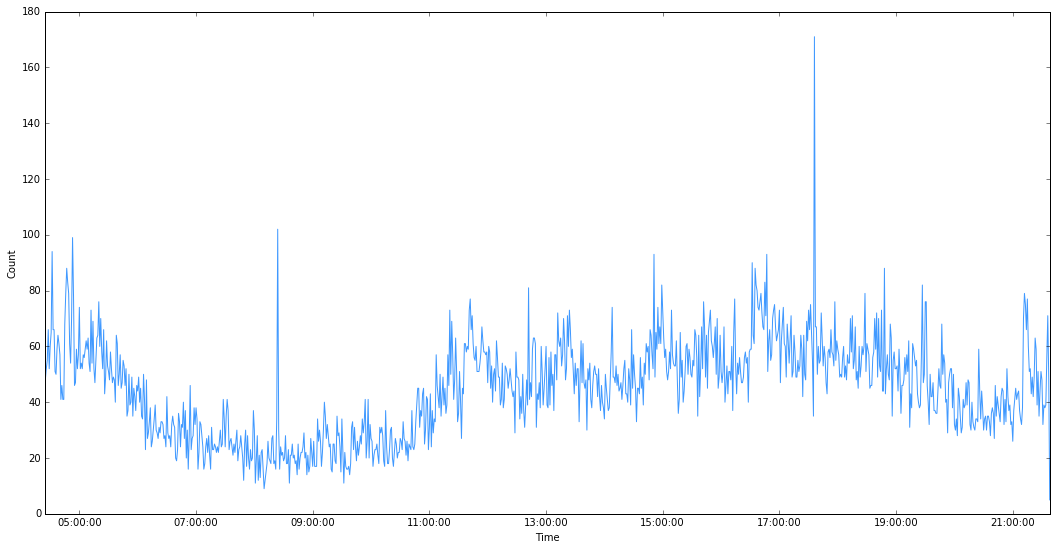

Tweets per minute:
Mean:      44.7359767892
Std. Dev:  16.9490701617
Min:       5
Max:       171


In [187]:
ones = [1] * len(all_dates)
idx = pandas.DatetimeIndex(all_dates)
event_series = pandas.Series(ones, index = idx)
per_minute = event_series.resample('1Min', how='sum').fillna(0)
plt.plot(per_minute, color='#4099FF')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()

print 'Tweets per minute:'
print 'Mean:     ',per_minute.mean()
print 'Std. Dev: ',per_minute.std()
print 'Min:      ',per_minute.min()
print 'Max:      ',per_minute.max()

***
As we can see from the previous graph, the resolution of one minute was good enought to detect two spikes that occurred during the day. The first one took place at **08:24 with 102 tweets** in the morning, while the second spike occurred in the evening at **17:36 with 171 tweets**.

### Morning Tweets

If we check the tweets that only occurred in the spike during the morning we can see a diverse set of news regarding several events such as:

1. Obama inviting Deray to the White House
2. The arrest of Asaram Bapu Ji
3. The arrest of a teenager in Liverpool
4. An arrest in Pakistan
5. An arrest in Belgium

However, Obama and Deray seem to be a common term among these tweets.

In [239]:
def get_minute_tweets(hour, minute):
    minute_tweets = set()
    for tweet in all_tweet_json:
        tweet_dt = dt.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC)
        if tweet_dt.hour == hour and tweet_dt.minute == minute and tweet['text'] not in minute_tweets:
            minute_tweets.add(tweet['text'])
    return minute_tweets

morning_tweets = get_minute_tweets(8,24)
print 'Total unique tweets at 8:24: ',len(morning_tweets)
for idx, tweet_text in zip(range(1, len(morning_tweets)+1),morning_tweets):
    print u'({}) {}'.format(idx, tweet_text)

Total unique tweets at 8:24:  23
(1) Teenager dies in police custody after shopping centre arrest - https://t.co/HCUiNcwu3i - ... https://t.co/eUxJPeQOGE
(2) RT @MistressReal: your Arrest clip for indecent exposure is done @maggot_matt . Will be sent to you at 9pm , call Me straight after!! https…
(3) RT @BahadurHariOm: @Pratibh94201732 @AmdAshram @ndtv #अन्याय_बंद_हो The arrest of Asaram Bapu Ji is a pre-planned conspiracy to malign a pi…
(4) RT @PoliticalShort: Not even a week after the killing of 5 cops by a man inspired by #BlackLivesMatter , Obama meets w/BLM racist Deray htt…
(5) Authorities decide to arrest poster campaigner https://t.co/xzo93afO1o
(6) @jonallendc @sierramike320 @deray was there a week ago, I believe, as well.
(7) RT @PoliticalShort: Meet the fifth column actively targeting America's law enforcement. Obama, Jarrett, Sharpton, &amp; vested puppet Deray. ht…
(8) People get the idea from TV that it's really easy to restart a heart or fix a heart attack. It's not. 3

### Evenining Tweets

The evening spike was formed by 63 unique tweets. In there we can still obseve tweets corresponding to Deray's arrest and his visit to the White House, while some new topics appear such as:

1. An arrest taking place in Italy.
2. A book named "House Arrest" being nominated for a prize.
3. The arrest of a man related with the disappearance of a girl after her mother died.

To mention some of them, here is the full list of the unique tweets found at that time of the day:

In [240]:
evening_tweets = get_minute_tweets(17,36)
print 'Total unique tweets at 17:36: ',len(evening_tweets)
for idx, tweet_text in zip(range(1, len(evening_tweets)+1),evening_tweets):
    print u'({}) {}'.format(idx, tweet_text)

Total unique tweets at 17:36:  63
(1) RT @pbpcourts: Nouman Raja’s lawyers postpone request for house arrest changes https://t.co/yV2slOW1Oo
(2) RT @LearnEnglish9: .@KSA24 
وزير minister (مينستر) 
حقوق الإنسان human rights (هيومان رايتس) 
حصار siege (سيج)
 يعتقل arrest (اريست)
.
.
شا…
(3) LN Padania: LA SCOMPARSA DEL CAPO DI COSA NOSTRA
Il poliziotto che arrestò Provenzano: "Non mi commuovo per la sua… https://t.co/4YkaBmAq2l
(4) Notified #twitter + RT to @FBIWFO @CivilRights @PressSec ..best to send all via 'messages.' Best to block+mute man. https://t.co/48Esap7C3k
(5) #BlackLivesMatter #blackLIESmatter #blm https://t.co/1N6ZGy9l81
(6) RT @TAXSTONE: How niggas mad at deray having a nice house Lmaoooooooooo holy shit you niggas need to die
(7) "You in the robes, put down the weapon of mass destruction and get down on the ground. You're under arrest!"
(8) !!! https://t.co/KKhfcuq6ZB
(9) We're not God, De-Ray, we're just White- that's all. https://t.co/6NUMzSiX5p
(10) Arrest in girl's d

## Discussion

In this first exploratory analysis we found that most of the tweets fully use the permitted 140 characters and that emojis are permitted as a combination of unicode characters. In the near future, it might be convenient to make an analysis of the emojis as those might reflect the opinion of the people with respect to a certain topic.

Then we found out that only 51.2% of the tweets in our corpus are unique, while almost the other half are repeated tweets. For this reason in order to obtain more information from the tweets' text, it is important to clean up the data by ignoring the words, tokens or terms related to a retweet or embedded URL. After cleaning the data in this way we could figure out that the important topic of the day was the visit of Deray McKesson after his arrest on the previous days. This was the main topic found with respect to the seed phrase *Black Lives Matter* to gather the corpus.

Bigrams and a word correlation analysis give more information than just unigrams, although an LDA analysis over the cleaned data gives more hints to disambiguate terms such as arrest. As many types of arrest were mentioned through the day. Abstracting the tweets through topic modelling techniques might be convenient to explore in depth to obtain more fine-grained information from a stream of tweets.

Then we found that the geolocation is not useful as most of the tweets are anonimized and just a drip have that information available. However if more geolocated tweets could be obtained, then it might become a powerful tool to discern the different events that happen during the day.

Finally in a shallow time-series analysis, we could see that two spikes occurred during the day. The spikes of activity proved to be a good source of information of the possible topics of what the rest of the day would be talking about. This can be considered as a double-edged sword, in which it can help detect more tweets in regard to the topics mentioned during the spike or as the detector of the broad topics which could be cut-off the corpus while trying to look for more sensitive information which cannot be found in the big mass of repeated information.

As following steps it might be a good idea to apply a sentiment analysis over the full timeline, which might help to skew different topics according to their polarity. A Named Entity extraction might be a good idea to find the import characters, locations and events taking place during the day and help refine a certain event search. As a final suggestion, it occurs to me that another possible way of doing topic modelling could be through a naive tf-idf clustering of the corpus.

In this first exploratory analysis, we could not observe any details with respect to the Dallas Shooting that took place 1 week before in July 7, 2016. But we found out that the public opinion of the leader of the *Black Lives Matter* became negative among black people as they found out he lived a comfortable life and was invited to speak at the White House. 